In [1]:
# Customer Segmentation Using RFM Analysis

#This project uses **RFM (Recency, Frequency, Monetary)** analysis to segment customers based on their purchasing behavior using the **Online Retail dataset**.

#The goal is to identify high-value customers, understand engagement patterns, and recommend targeted marketing strategies for each segment.


In [2]:
## Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

# Display settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)



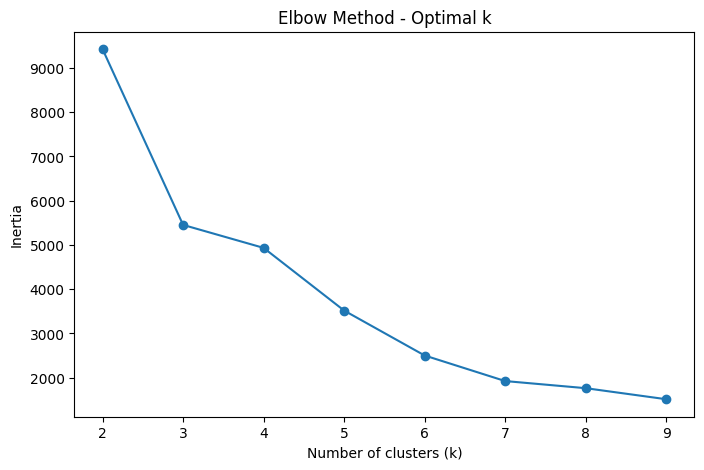

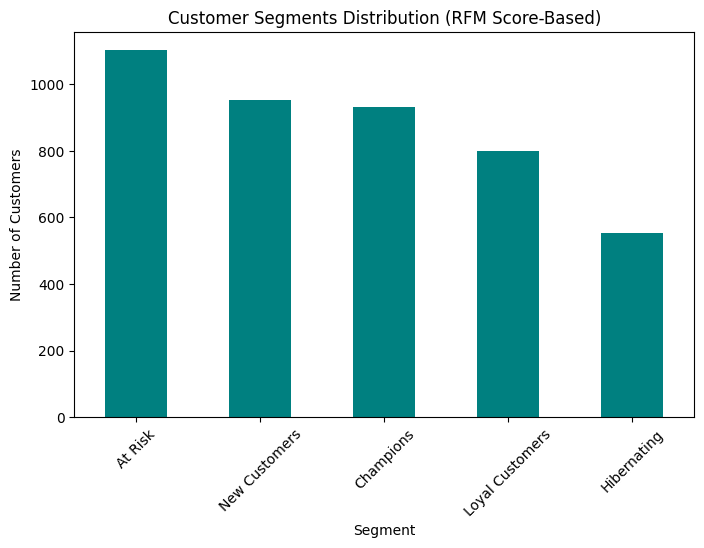

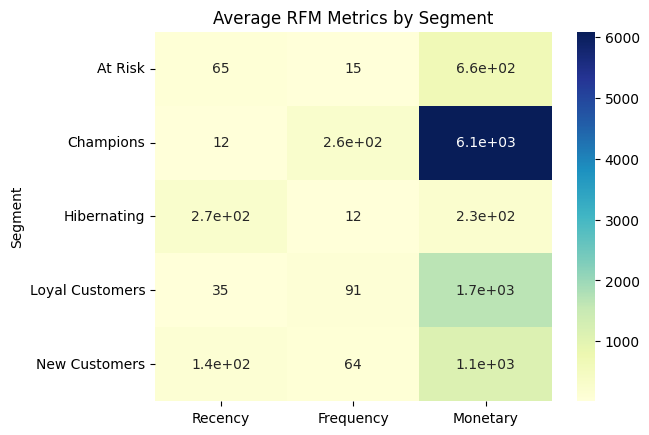

Segmentation results saved as RFM_Cluster.csv


In [3]:
# Step 2: Load and Explore the Dataset
#The dataset contains customer transaction details including: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID and Country.


data = pd.read_csv("OnlineRetail.csv", encoding='unicode_escape')

# Convert InvoiceDate to datetime 
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

# Step 3: Data Cleaning
data = data[data['CustomerID'].notnull()]
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Step 4: Definethe latest date in the dataset(recent_date)
recent_date = data['InvoiceDate'].max()

# Step 5: RFM metrics
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (recent_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                   # Frequency
    'TotalPrice': 'sum'                                     # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Step 6: Calculate R, F, M scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Step 7: Combine RFM Score
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

# Step 8: Segmentation 
def segment_customer(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif r >= 2 and f <= 2:
        return 'At Risk'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Hibernating'
    else:
        return 'New Customers'

rfm['Segment_RFMScore'] = rfm.apply(segment_customer, axis=1)

# Step 9: Marketing ideas
marketing_ideas = {
    'Champions': 'Reward them with exclusive discounts or loyalty programs.',
    'Loyal Customers': 'Offer personalized recommendations and appreciation deals.',
    'At Risk': 'Send reactivation emails or limited-time offers.',
    'New Customers': 'Welcome them with onboarding messages and small discounts.',
    'Hibernating': 'Re-engage with reactivation campaigns or surveys.'
}

rfm['Marketing_Action'] = rfm['Segment_RFMScore'].map(marketing_ideas)

# Step 10: K-Means Clustering (optional)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Optimal k')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 11: Visualization
rfm['Segment'] = rfm['Segment_RFMScore']

# Bar Chart
plt.figure(figsize=(8,5))
rfm['Segment'].value_counts().plot(kind='bar', color='teal')
plt.title('Customer Segments Distribution (RFM Score-Based)')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)  
plt.show()

# Heatmap
rfm_agg = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
sns.heatmap(rfm_agg, annot=True, cmap='YlGnBu')
plt.title('Average RFM Metrics by Segment')
plt.show()

# Save CSV
rfm.to_csv('RFM_Cluster.csv', index=False)
print("Segmentation results saved as RFM_Cluster.csv")

